In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sellin = pd.read_csv("datasets/sell-in.csv", sep='\t')
productos = pd.read_csv("datasets/tb_productos.csv", sep='\t')
stocks = pd.read_csv("datasets/tb_stocks.csv", sep='\t')

In [4]:
# Verificación inicial
print(f"Sell-In: {sellin.shape[0]} filas y {sellin.shape[1]} columnas")
print(f"Productos: {productos.shape[0]} filas y {productos.shape[1]} columnas")
print(f"Stocks: {stocks.shape[0]} filas y {stocks.shape[1]} columnas")

Sell-In: 2945818 filas y 7 columnas
Productos: 1262 filas y 6 columnas
Stocks: 13691 filas y 3 columnas


In [5]:
# 3. MERGE INICIAL
df = sellin.merge(productos, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(f"Ventas-Productos-Stocks: {df.shape[0]} filas y {df.shape[1]} columnas")

Ventas-Productos-Stocks: 2988650 filas y 13 columnas


In [6]:
productos_clean = productos.drop_duplicates(subset=['product_id'], keep='first')
print(productos_clean.shape)

(1251, 6)


In [7]:
df = sellin.merge(productos_clean, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(sellin.shape)
print(df.shape)

(2945818, 7)
(2945818, 13)


In [8]:
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

## Stock

In [13]:
stocks

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595
...,...,...,...
13686,201912,20453,1.43741
13687,201912,21026,7.26817
13688,201912,21054,0.50833
13689,201912,20981,2.18491


In [30]:
# Asegurar ventas positivas
ventas = df[df['tn'] > 0].copy()

# Calcular cuántos meses únicos con ventas tuvo cada producto
historial = (
    ventas.groupby('product_id')['periodo']
    .nunique()
    .reset_index(name='meses_con_ventas')
)

# Definir el total de meses del histórico disponible
total_meses = df['periodo'].nunique()

# Filtrar productos que:
# - tienen más de 3 meses con ventas
# - tienen el total de meses esperados (por ejemplo 36)
productos_estables = historial[historial['meses_con_ventas'] >= 24]['product_id'].tolist()

# Filtrar el DataFrame original para esos productos
df_productos_estables = df[df['product_id'].isin(productos_estables)]

print(f"🔎 Se encontraron {len(productos_estables)} productos estables (vendidos todos los meses del histórico).")


🔎 Se encontraron 780 productos estables (vendidos todos los meses del histórico).


In [44]:
import io
import math
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose

def descomposicion_serie_productos_por_cat(df, cat1=None, cat2=None):
    """
    Aplica seasonal_decompose o grafica la serie por cada product_id
    dentro de cada combinación cat1, cat2 y cat3.
    """

    # Filtrar combinaciones válidas
    subset = df[(df['cat1'] == cat1) & (df['cat2'] == cat2) & (df['tn'] > 0)].copy()
    if subset.empty:
        return

    subset['periodo_dt'] = pd.to_datetime(subset['periodo'].astype(str), format='%Y%m')

    # Recorrer cada cat3 dentro del cat1 y cat2 actual
    for cat3 in subset['cat3'].dropna().unique():
        ventas = subset[subset['cat3'] == cat3].copy()

        # Agrupar por producto y mes
        ventas_agrupadas = (
            ventas.groupby(['product_id', 'periodo_dt'])['tn']
            .sum()
            .reset_index()
            .sort_values(['product_id', 'periodo_dt'])
        )

        product_ids = ventas_agrupadas['product_id'].unique()
        n = len(product_ids)
        n_cols = 2
        n_rows = math.ceil(n / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
        axes = axes.flatten()

        for i, product_id in enumerate(product_ids):
            serie = (
                ventas_agrupadas[ventas_agrupadas['product_id'] == product_id]
                .set_index('periodo_dt')['tn']
                .asfreq('MS')
            )

            ax = axes[i]

            try:
                if serie.notna().sum() >= 12:
                    resultado = seasonal_decompose(serie, model='additive', period=12)
                    ax.plot(serie.index, serie.values, label='Serie original', alpha=0.5, color='black')
                    ax.plot(resultado.trend.index, resultado.trend.values, label='Tendencia', color='blue')
                    ax.plot(resultado.seasonal.index, resultado.seasonal.values, label='Estacionalidad', linestyle='--', color='green')
                    ax.set_title(f"{cat1} - {cat2} - {cat3} - ID {product_id}")
                else:
                    ax.plot(serie.index, serie.values, marker='o', linestyle='-', color='gray')
                    ax.set_title(f"{cat1} - {cat2} - {cat3} - ID {product_id} (sin descomposición)")

                # Línea vertical en enero
                for fecha in serie.index:
                    if fecha.month == 1:
                        ax.axvline(x=fecha, color='gray', linestyle=':', linewidth=2)

                ax.set_xlabel("Periodo")
                ax.set_ylabel("Toneladas vendidas")
                ax.tick_params(axis='x', rotation=45)
                ax.legend()

            except Exception as e:
                print(f"Error en producto {product_id}: {e}")
                fig.delaxes(ax)

        # Eliminar ejes vacíos
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()




# Obtener combinaciones únicas de cat1 y cat2, eliminando valores nulos en cat1
combinaciones = df[['cat1', 'cat2']].dropna(subset=['cat1']).drop_duplicates()

# Recorrer cada combinación y aplicar el gráfico
for _, fila in combinaciones.iterrows():
    cat1 = fila['cat1']
    cat2 = fila['cat2']
    
    print(f"\n📈 Generando gráfico para: cat1 = {cat1} | cat2 = {cat2}")
    descomposicion_serie_productos_por_cat(df, cat1=cat1, cat2=cat2)


📈 Generando gráfico para: cat1 = HC | cat2 = VAJILLA


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

def graficar_series_con_tendencia(df, cat1, cat2):
    """
    Grafica la serie original y su tendencia lineal para cada producto (por cat1, cat2, cat3).
    Incluye líneas punteadas en enero.
    """
    subset = df[(df['cat1'] == cat1) & (df['cat2'] == cat2) & (df['tn'] > 0)].copy()
    if subset.empty:
        print(f"No hay datos para cat1={cat1} y cat2={cat2}")
        return

    subset['periodo_dt'] = pd.to_datetime(subset['periodo'].astype(str), format='%Y%m')

    for cat3 in subset['cat3'].dropna().unique():
        df_cat3 = subset[subset['cat3'] == cat3]
        product_ids = df_cat3['product_id'].unique()
        n = len(product_ids)
        n_cols = 2
        n_rows = math.ceil(n / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
        axes = axes.flatten()

        for i, product_id in enumerate(product_ids):
            serie = (
                df_cat3[df_cat3['product_id'] == product_id]
                .groupby('periodo_dt')['tn']
                .sum()
                .sort_index()
            )

            # Asegurar continuidad de fechas
            fechas = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='MS')
            serie = serie.reindex(fechas, fill_value=0)

            ax = axes[i]
            ax.plot(serie.index, serie.values, marker='o', linestyle='-', color='steelblue', label='Serie original')

            # Calcular línea de tendencia
            x = np.arange(len(serie))
            y = serie.values
            coef = np.polyfit(x, y, 1)  # Ajuste lineal
            tendencia = np.polyval(coef, x)
            ax.plot(serie.index, tendencia, color='crimson', linestyle='--', linewidth=2, label='Tendencia lineal')

            # Personalización
            ax.set_title(f"{cat1} - {cat2} - {cat3} - ID {product_id}")
            ax.set_xlabel("Periodo")
            ax.set_ylabel("Toneladas")
            ax.tick_params(axis='x', rotation=45)

            # Líneas verticales en enero
            for fecha in serie.index:
                if fecha.month == 1:
                    ax.axvline(x=fecha, color='gray', linestyle=':', linewidth=1)

            ax.legend()

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

# Obtener combinaciones únicas de cat1 y cat2, eliminando valores nulos en cat1
combinaciones = df[['cat1', 'cat2']].dropna(subset=['cat1']).drop_duplicates()

# Recorrer cada combinación y aplicar el gráfico
for _, fila in combinaciones.iterrows():
    cat1 = fila['cat1']
    cat2 = fila['cat2']
    
    print(f"\n📈 Generando gráfico para: cat1 = {cat1} | cat2 = {cat2}")
    graficar_series_con_tendencia(df, cat1=cat1, cat2=cat2)


📈 Generando gráfico para: cat1 = HC | cat2 = VAJILLA


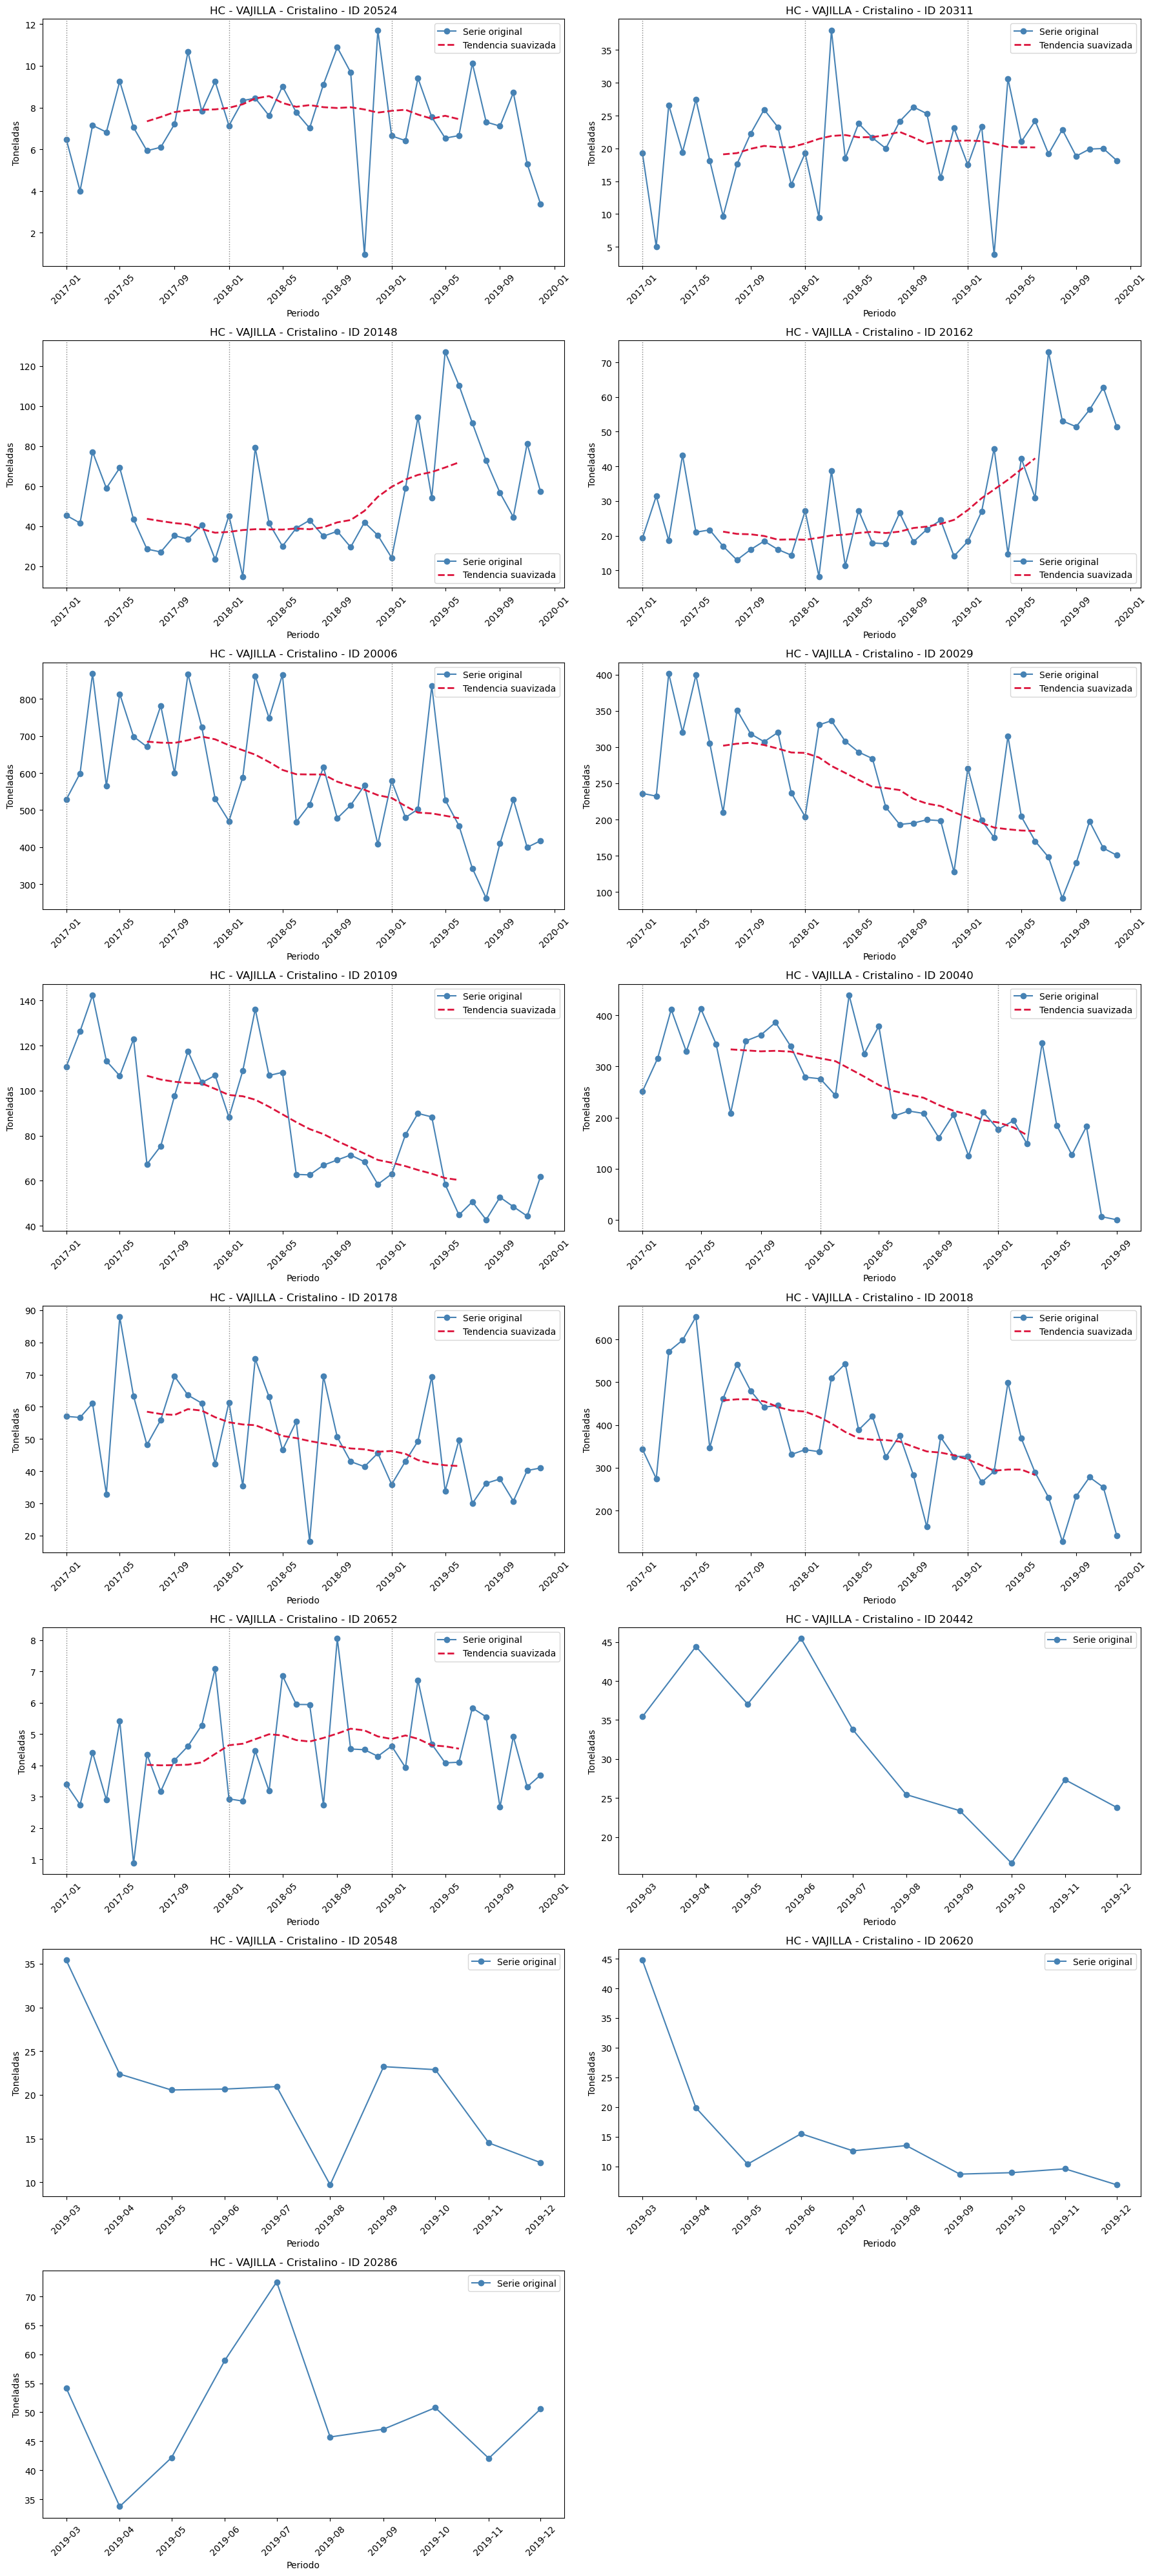

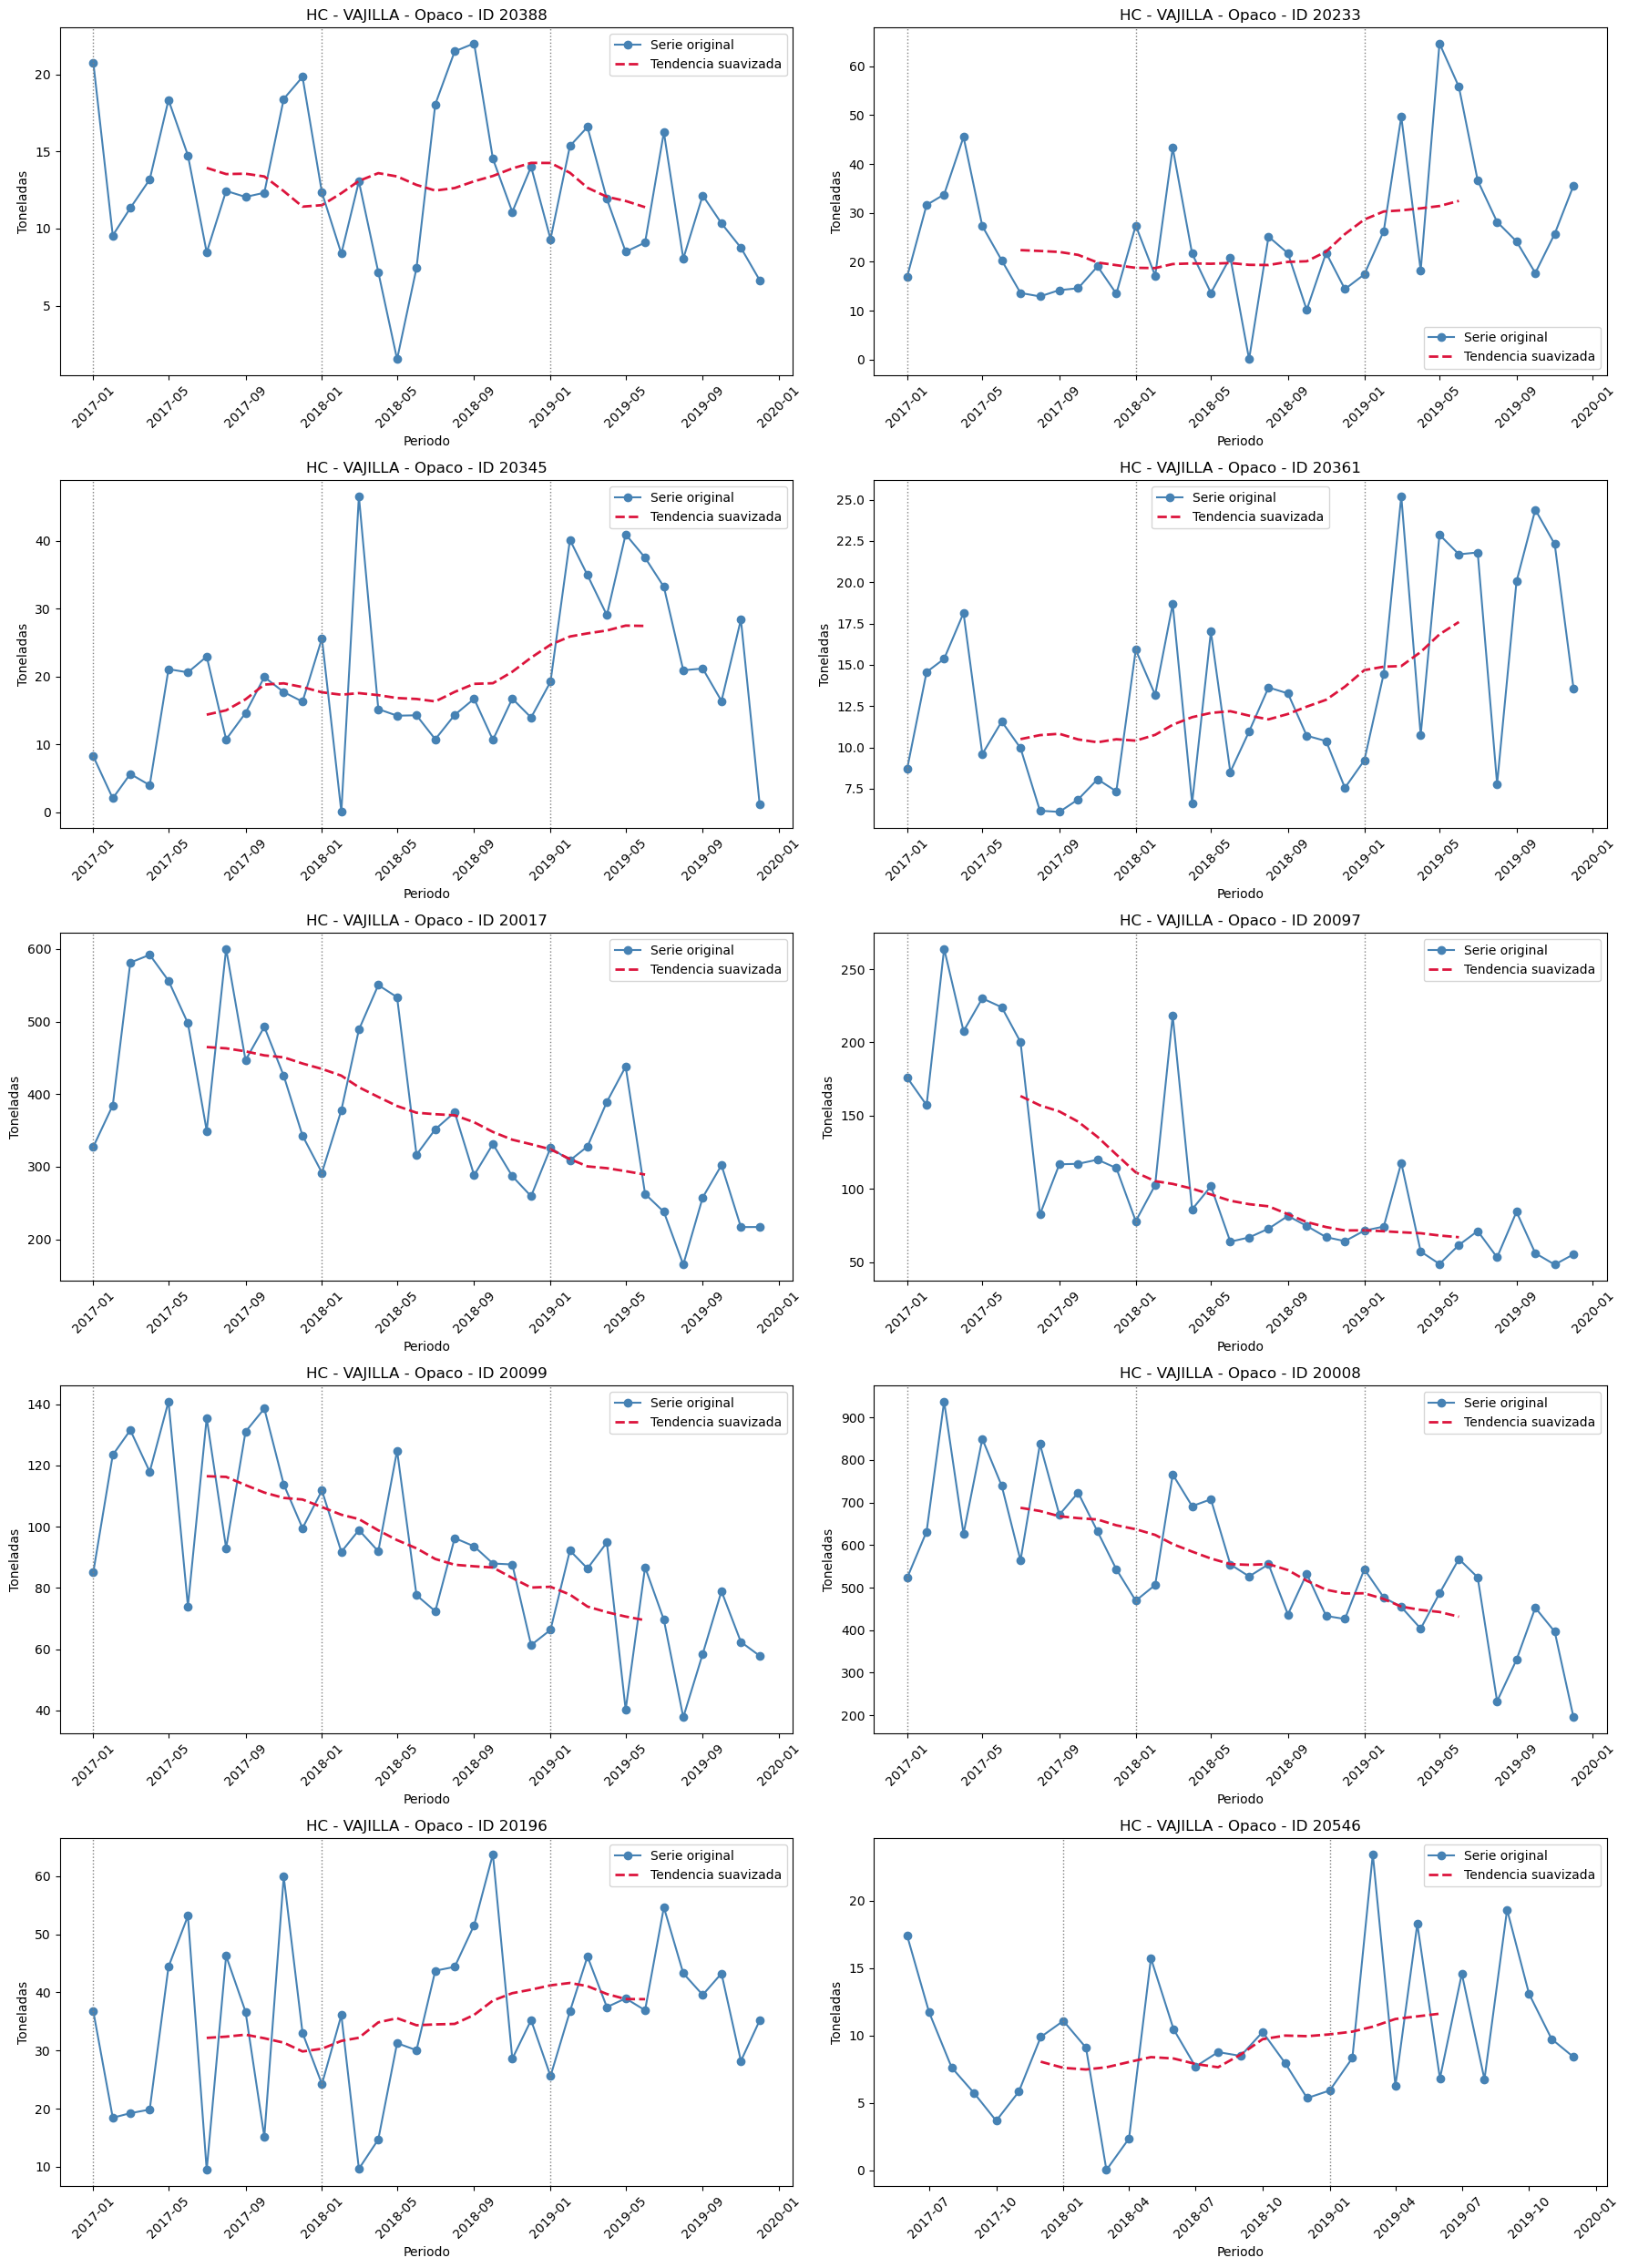

KeyboardInterrupt: 

In [47]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

def graficar_series_con_tendencia_suavizada(df, cat1, cat2):
    """
    Grafica la serie original de cada producto (cat1-cat2-cat3) con su tendencia suavizada
    usando seasonal_decompose. Agrega líneas punteadas en cada enero.
    """
    subset = df[(df['cat1'] == cat1) & (df['cat2'] == cat2) & (df['tn'] > 0)].copy()
    if subset.empty:
        print(f"No hay datos para cat1={cat1} y cat2={cat2}")
        return

    subset['periodo_dt'] = pd.to_datetime(subset['periodo'].astype(str), format='%Y%m')

    for cat3 in subset['cat3'].dropna().unique():
        df_cat3 = subset[subset['cat3'] == cat3]
        product_ids = df_cat3['product_id'].unique()
        n = len(product_ids)
        n_cols = 2
        n_rows = math.ceil(n / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
        axes = axes.flatten()

        for i, product_id in enumerate(product_ids):
            serie = (
                df_cat3[df_cat3['product_id'] == product_id]
                .groupby('periodo_dt')['tn']
                .sum()
                .sort_index()
            )

            # Crear rango completo mensual
            fechas_completas = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='MS')
            serie = serie.reindex(fechas_completas, fill_value=0)

            ax = axes[i]
            ax.plot(serie.index, serie.values, marker='o', linestyle='-', color='steelblue', label='Serie original')

            # Graficar la tendencia suavizada si hay suficiente info
            if serie.notna().sum() >= 24:
                resultado = seasonal_decompose(serie, model='additive', period=12)
                tendencia = resultado.trend
                ax.plot(tendencia.index, tendencia.values, color='crimson', linestyle='--', linewidth=2, label='Tendencia suavizada')

            ax.set_title(f"{cat1} - {cat2} - {cat3} - ID {product_id}")
            ax.set_xlabel("Periodo")
            ax.set_ylabel("Toneladas")
            ax.tick_params(axis='x', rotation=45)

            # Línea vertical en enero
            for fecha in serie.index:
                if fecha.month == 1:
                    ax.axvline(x=fecha, color='gray', linestyle=':', linewidth=1)

            ax.legend()

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

# Recorrer cada combinación y aplicar el gráfico
for _, fila in combinaciones.iterrows():
    cat1 = fila['cat1']
    cat2 = fila['cat2']
    
    print(f"\n📈 Generando gráfico para: cat1 = {cat1} | cat2 = {cat2}")
    graficar_series_con_tendencia_suavizada(df, cat1=cat1, cat2=cat2)